In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Testing stat defense vs. blackbox attack

Steps:
Load data
Train defense model on data
Use defense model as 'oracle' for substitute (replace targets in data with defense model's predictions)
Train substitute on data with targets replaced by oracle (optionally using Jacobian-based data augmentation)
Generate attack data against substitute model
Test defense model against attack data
"""

"\nTesting stat defense vs. blackbox attack\n\nSteps:\nLoad data\nTrain defense model on data\nUse defense model as 'oracle' for substitute (replace targets in data with defense model's predictions)\nTrain substitute on data with targets replaced by oracle (optionally using Jacobian-based data augmentation)\nGenerate attack data against substitute model\nTest defense model against attack data\n"

In [3]:
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.autograd.functional import jacobian
from torch.autograd import grad
from sklearn.model_selection import train_test_split

import team36
from team36.mnist.data_loading import MNIST_Loader
from team36.mnist.vgg import VGG
from team36.mnist.cnn import CNN
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss
from team36.training import train, validate, accuracy, predict, predict_from_loader, do_training, load_or_train, train_val_split, train_batch

DIR = '.'
DATA_DIR = f'{DIR}/data'

In [4]:
"""
Set up the datasets
It is interesting to compare using the same dataset for the substitute and oracle vs. using different datasets
"""
ORACLE_DATASET = 'MNIST' # 'MNIST' or 'CIFAR10'
SUB_DATASET = 'MNIST' 
DATASET_NAMES = [ORACLE_DATASET, SUB_DATASET]
MODEL_NAMES = ['oracle', 'sub']
ORACLE = 0
SUB = 1
datasets = [] # two-element list to store the oracle dataset and the substitute dataset
dataset_image_sizes = []
dataset_channels = []
test_datasets = []

for idx, dataset_name in enumerate(DATASET_NAMES):
    transform_seq = [transforms.ToTensor()]
    if dataset_name == 'MNIST':
        image_size = 28
        in_channels = 1
        if idx == SUB and ORACLE_DATASET != 'MNIST': # if substitute uses mnist, but oracle uses other dataset add padding to match image size
            padding = (dataset_image_sizes[ORACLE] - image_size) // 2
            transform_seq.append(transforms.Pad(padding, fill=0))
            image_size += padding * 2
            transform_seq.append(transforms.Lambda(lambda x: x.repeat(3, 1, 1)))
            in_channels = 3 # also need to copy to 3 channels to match rgb cifar
            # NOTE: above assumes oracle_dataset has larger images and that there is an even number difference in the image sizes
        dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                              transform=transforms.Compose(transform_seq))
        test_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
                                              transform=transforms.Compose(transform_seq))
    elif dataset_name == 'CIFAR10':
        image_size = 32
        in_channels = 3
        dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True,
                                                transform=transforms.Compose(transform_seq))
        test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, 
                                              transform=transforms.Compose(transform_seq))
    else:
        print('ERROR: invalid dataset name', dataset_name)
    datasets.append(dataset)
    dataset_image_sizes.append(image_size)
    dataset_channels.append(in_channels)
    test_datasets.append(test_dataset)

# optionally, use the test set to train the substitute, so that it trains on different data than the oracle:
# datasets[SUB] = test_datasets[SUB]
    
datasets

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            )]

In [5]:
"""Initialize the defense model (aka the oracle)"""
if DATASET_NAMES[ORACLE] == 'MNIST':
    defense_model = VGG() #TODO: replace with defense model
elif DATASET_NAMES[ORACLE] == 'CIFAR10':
    defense_model = VGG(image_size=32, in_channels=3) #TODO: replace with defense model
oracle = defense_model
    
defense_model

VGG(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_l

In [6]:
"""Train the defense model"""
torch.manual_seed(0)
#TODO: train defense_model using datasets[ORACLE]
# insert your own training code, or use load_or_train() from training.py if it helps
# note that load_or_train() generates a checkpoint with the given name and you need to delete it if you want to re-train from scratch

In [7]:
%%time
"""Relabel the substitute dataset with the oracle's predictions"""
loader = torch.utils.data.DataLoader(datasets[SUB], batch_size=100, shuffle=False, num_workers=0)
oracle_preds = predict_from_loader(oracle, loader)

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0
C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mo

Wall time: 1min 27s


In [8]:
%%time
oracle_preds = oracle_preds.argmax(axis=1)

Wall time: 6.49 ms


In [9]:
# sanity check: oracle preds should mostly match true labels (i.e. close to 60,000 on MNIST or 50,000 on CIFAR10)
len(oracle_preds[oracle_preds == datasets[SUB].targets]) 

10774

In [10]:
# replace true labels with oracle's predictions
datasets[SUB].targets = oracle_preds 

1800 in training set
1800 in validation set
Epoch: [0][0/8]	Loss 2.2591 (2.2591)	Prec @1 0.0547 (0.0547)	
Epoch 0 | Training accuracy: 0.5529999732971191% | Validation accuracy: 0.6272222399711609%
Epoch: [1][0/8]	Loss 0.7616 (0.7616)	Prec @1 0.7031 (0.7031)	
Epoch 1 | Training accuracy: 0.703000009059906% | Validation accuracy: 0.6238889098167419%
Epoch: [2][0/8]	Loss 0.8500 (0.8500)	Prec @1 0.6562 (0.6562)	
Epoch 2 | Training accuracy: 0.7089999914169312% | Validation accuracy: 0.6555555462837219%
Epoch: [3][0/8]	Loss 0.7790 (0.7790)	Prec @1 0.7578 (0.7578)	
Epoch 3 | Training accuracy: 0.746999979019165% | Validation accuracy: 0.6622222065925598%
Epoch: [4][0/8]	Loss 0.6857 (0.6857)	Prec @1 0.7656 (0.7656)	
Epoch 4 | Training accuracy: 0.718999981880188% | Validation accuracy: 0.6638888716697693%
Epoch: [5][0/8]	Loss 0.8107 (0.8107)	Prec @1 0.7031 (0.7031)	
Epoch 5 | Training accuracy: 0.7039999961853027% | Validation accuracy: 0.5888888835906982%
Epoch: [6][0/8]	Loss 0.8534 (0.8534

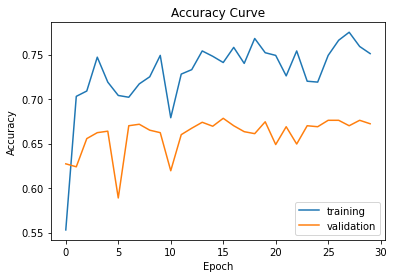

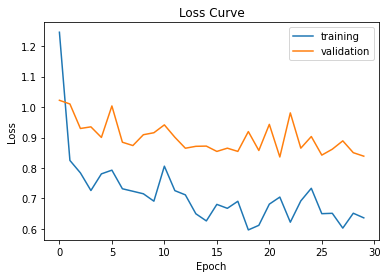

Best Validation Acccuracy: 0.6783
Wall time: 22.5 s


In [11]:
%%time
torch.manual_seed(0)
sub = CNN(image_size = dataset_image_sizes[SUB], in_channels = dataset_channels[SUB])
sub_checkpoint = f'{DATASET_NAMES[SUB]}-substitute.pth' # e.g. 'MNIST-substitute.pth'

loader = torch.utils.data.DataLoader(datasets[SUB], batch_size=100, shuffle=False, num_workers=0)
# NOTE: due to a bug with lambda transforms on Windows, num_workers needs to be 0 or there will be an error
# https://github.com/belskikh/kekas/issues/26

epochs = 30
#TODO: test with train_size 1800 and 10,000, and tune hyperparameters if necessary
# train_size = 10000
train_size = 1800 
learning_rate = 0.05
momentum = 0.5
train = Subset(datasets[SUB], range(train_size))
val = Subset(datasets[SUB], range(train_size, train_size*2)) # val split same size as train split
load_or_train(sub, sub_checkpoint, train_split=train, val_split=val, epochs=epochs, learning_rate=learning_rate, momentum=momentum)

In [12]:
target = oracle
criterion = nn.CrossEntropyLoss()
models = [(oracle, 'oracle')]

In [13]:
%%time
"""Regular Test"""
test_set = test_datasets[ORACLE] 

for model, name in models:
    print(name)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=0)

    test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)

    print(f"{name} Regular Test Accuracy is {test_accuracy}")
    print(f"{name} Regular Test Loss is {test_loss}")

oracle
oracle Regular Test Accuracy is 0.18129999935626984
oracle Regular Test Loss is 2.4282011222839355
Wall time: 15.7 s


In [14]:
%%time
"""Attack Test"""
epsilon = 0.25 #TODO: record results for epsilon=0.25, 0.1, 0.05, and 0.01
test_set = test_datasets[ORACLE] # since the substitute tries to mimic the oracle, we may as well test on the oracle's test set
attack_test_set = FastSignGradientAttackDataSet(test_set, sub, criterion, epsilon=epsilon) # generate attack against substitute model

for model, name in models:
    print(name)
    test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, shuffle=False, num_workers=0)

    test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)

    print(f"{name} Attack Test Accuracy is {test_accuracy}")
    print(f"{name} Attack Test Loss is {test_loss}")

oracle
oracle Attack Test Accuracy is 0.13359999656677246
oracle Attack Test Loss is 2.5852762818336488
Wall time: 22.8 s
